Shape: (200, 5)
   Gender  Age  Annual Income (k$)  Spending Score (1-100)  Cluster
0     1.0   19                  15                      39        4
1     1.0   21                  15                      81        2
2     0.0   20                  16                       6        4
3     0.0   23                  16                      77        2
4     0.0   31                  17                      40        4

Columns: ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Cluster']
Using features: ['Annual Income (k$)', 'Spending Score (1-100)']


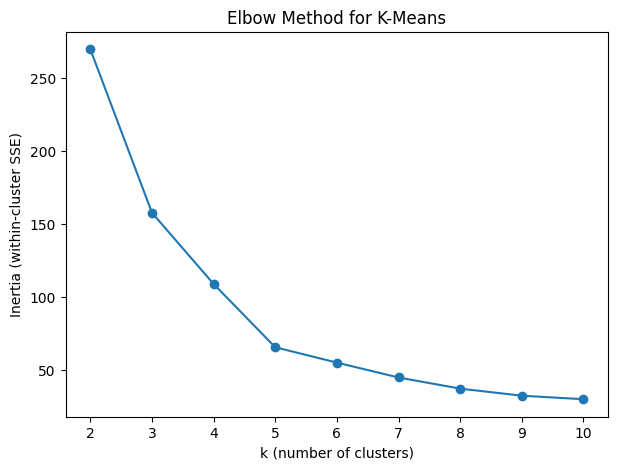

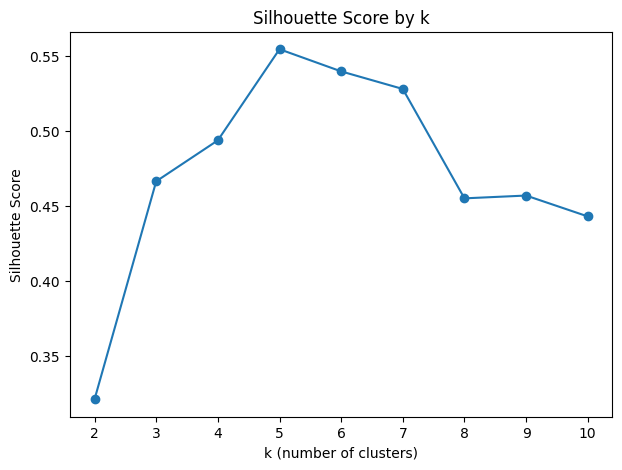

Silhouette by k:
k=2: silhouette=0.321
k=3: silhouette=0.467
k=4: silhouette=0.494
k=5: silhouette=0.555
k=6: silhouette=0.540
k=7: silhouette=0.528
k=8: silhouette=0.455
k=9: silhouette=0.457
k=10: silhouette=0.443

Selected best_k (by silhouette): 5
K-Means Metrics (k=5)
Silhouette Score: 0.555
Calinski-Harabasz: 248.6
Davies-Bouldin: 0.572


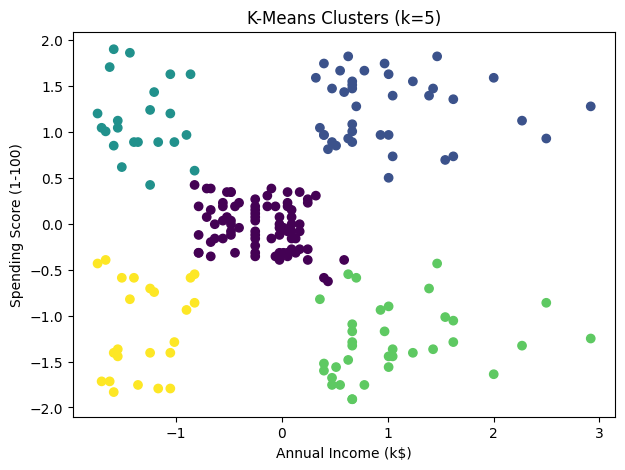


Cluster Profile (Income & Spending):
        Annual Income (k$)              Spending Score (1-100)             
                      mean median count                   mean median count
Cluster                                                                    
0                55.296296   54.0    81              49.518519   50.0    81
1                86.538462   79.0    39              82.128205   83.0    39
2                25.727273   24.5    22              79.363636   77.0    22
3                88.200000   85.0    35              17.114286   16.0    35
4                26.304348   25.0    23              20.913043   17.0    23

Best DBSCAN params: eps=0.40, min_samples=5
Best DBSCAN Silhouette: 0.413


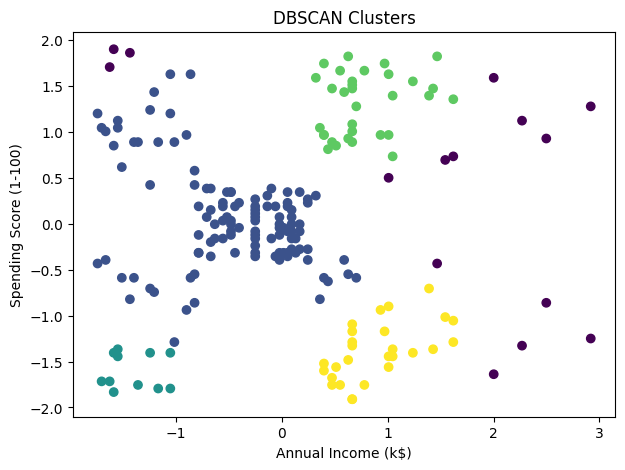


DBSCAN Cluster Profile (non-noise):
        Annual Income (k$)              Spending Score (1-100)             
                      mean median count                   mean median count
Cluster                                                                    
0                48.304348   49.0   115              51.730435   50.0   115
1                23.727273   20.0    11               8.909091    6.0    11
2                80.875000   78.0    32              83.625000   86.0    32
3                83.925926   81.0    27              14.444444   14.0    27

Saved: mall_customers_with_clusters.csv, mall_cluster_profile.csv


In [2]:
# 🛍️ Customer Segmentation (Mall Customers)
# Unsupervised learning with K-Means + DBSCAN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

plt.rcParams['figure.figsize'] = (7,5)

# Load Dataset
df = pd.read_csv('/content/mall_customers_with_clusters.csv')
print('Shape:', df.shape)
print(df.head())

# Basic Cleaning & Feature Engineering
if 'CustomerID' in df.columns:
    df = df.drop(columns=['CustomerID'])

if 'Gender' in df.columns:
    df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0}).astype('float64')

for col in df.columns:
    if df[col].dtype != 'O':
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

print('\nColumns:', df.columns.tolist())

# Feature Selection & Scaling
feature_cols = []
for name in ['Annual Income (k$)', 'Spending Score (1-100)']:
    if name in df.columns:
        feature_cols.append(name)

if not feature_cols:
    for name in ['Annual Income', 'Annual_Income', 'Spending Score', 'Spending_Score']:
        if name in df.columns:
            feature_cols.append(name)

X = df[feature_cols].copy()
print('Using features:', feature_cols)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means — Find Optimal k
ks = range(2, 11)
inertias = []
sil_scores = []
for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.plot(ks, inertias, marker='o')
plt.xlabel('k (number of clusters)')
plt.ylabel('Inertia (within-cluster SSE)')
plt.title('Elbow Method for K-Means')
plt.show()

plt.plot(ks, sil_scores, marker='o')
plt.xlabel('k (number of clusters)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by k')
plt.show()

print('Silhouette by k:')
for k, s in zip(ks, sil_scores):
    print(f'k={k}: silhouette={s:.3f}')

best_k = ks[int(np.argmax(sil_scores))]
print(f'\nSelected best_k (by silhouette): {best_k}')

# Train Final K-Means & Evaluate
km_final = KMeans(n_clusters=best_k, n_init=25, random_state=42)
labels_km = km_final.fit_predict(X_scaled)

sil = silhouette_score(X_scaled, labels_km)
ch = calinski_harabasz_score(X_scaled, labels_km)
db = davies_bouldin_score(X_scaled, labels_km)

print(f"K-Means Metrics (k={best_k})")
print(f"Silhouette Score: {sil:.3f}")
print(f"Calinski-Harabasz: {ch:.1f}")
print(f"Davies-Bouldin: {db:.3f}")

# Visualization (2D)
if X_scaled.shape[1] > 2:
    pca = PCA(n_components=2, random_state=42)
    X_vis = pca.fit_transform(X_scaled)
    x1, x2 = X_vis[:,0], X_vis[:,1]
    plt.scatter(x1, x2, c=labels_km)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'K-Means Clusters (k={best_k}) — PCA 2D')
    plt.show()
else:
    plt.scatter(X_scaled[:,0], X_scaled[:,1], c=labels_km)
    plt.xlabel(feature_cols[0])
    plt.ylabel(feature_cols[1])
    plt.title(f'K-Means Clusters (k={best_k})')
    plt.show()

# Cluster Profiling
clustered = X.copy()
clustered['Cluster'] = labels_km
profile = clustered.groupby('Cluster').agg(['mean','median','count'])
print('\nCluster Profile (Income & Spending):')
print(profile)

# DBSCAN — Density-Based Clustering
eps_values = np.linspace(0.2, 1.2, 6)
min_samples_values = [3, 5, 7, 10]

best_sil = -1
best_params = None
best_labels = None

for eps in eps_values:
    for ms in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=ms)
        labels = dbscan.fit_predict(X_scaled)
        unique = set(labels)
        if len(unique - {-1}) >= 2:
            s = silhouette_score(X_scaled, labels)
            if s > best_sil:
                best_sil = s
                best_params = (eps, ms)
                best_labels = labels

if best_params:
    print(f"\nBest DBSCAN params: eps={best_params[0]:.2f}, min_samples={best_params[1]}")
    print(f"Best DBSCAN Silhouette: {best_sil:.3f}")
    labels_db = best_labels

    if X_scaled.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        X_vis = pca.fit_transform(X_scaled)
        x1, x2 = X_vis[:,0], X_vis[:,1]
        plt.scatter(x1, x2, c=labels_db)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('DBSCAN Clusters — PCA 2D')
        plt.show()
    else:
        plt.scatter(X_scaled[:,0], X_scaled[:,1], c=labels_db)
        plt.xlabel(feature_cols[0])
        plt.ylabel(feature_cols[1])
        plt.title('DBSCAN Clusters')
        plt.show()

    clustered_db = X.copy()
    clustered_db['Cluster'] = labels_db
    clustered_db = clustered_db[clustered_db['Cluster'] != -1]
    profile_db = clustered_db.groupby('Cluster').agg(['mean','median','count'])
    print('\nDBSCAN Cluster Profile (non-noise):')
    print(profile_db)
else:
    print('\nDBSCAN could not form stable clusters with the tested grid. Try adjusting eps/min_samples.')

# Export Results
out = df.copy()
out['Cluster'] = labels_km
out.to_csv('mall_customers_with_clusters.csv', index=False)
profile.to_csv('mall_cluster_profile.csv')
print('\nSaved: mall_customers_with_clusters.csv, mall_cluster_profile.csv')
